In [30]:
import pandas as pd
import os

pd.set_option('display.max_colwidth', None)

## Посмотрим структуру данных

In [91]:
# Получаем список файлов
files = os.listdir('./data/daily_wind_speed/2020')

# Выводим только первые 5 файлов
first_five_files = files[:5]
print(first_five_files)


['00841599999.csv', '01001099999.csv', '01001499999.csv', '01002099999.csv', '01003099999.csv']


In [21]:
df = pd.read_csv('./data/daily_wind_speed/2025/01001499999.csv')

In [22]:
df.head()            # посмотреть первые строки
df.info()            # типы данных и пропуски
df.describe()        # статистика по числовым столбцам
df.isnull().sum()    # количество пропусков по каждому столбцу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STATION           82 non-null     int64  
 1   DATE              82 non-null     object 
 2   LATITUDE          82 non-null     float64
 3   LONGITUDE         82 non-null     float64
 4   ELEVATION         82 non-null     float64
 5   NAME              82 non-null     object 
 6   TEMP              82 non-null     float64
 7   TEMP_ATTRIBUTES   82 non-null     int64  
 8   DEWP              82 non-null     float64
 9   DEWP_ATTRIBUTES   82 non-null     int64  
 10  SLP               82 non-null     float64
 11  SLP_ATTRIBUTES    82 non-null     int64  
 12  STP               82 non-null     float64
 13  STP_ATTRIBUTES    82 non-null     int64  
 14  VISIB             82 non-null     float64
 15  VISIB_ATTRIBUTES  82 non-null     int64  
 16  WDSP              82 non-null     float64
 17 

STATION             0
DATE                0
LATITUDE            0
LONGITUDE           0
ELEVATION           0
NAME                0
TEMP                0
TEMP_ATTRIBUTES     0
DEWP                0
DEWP_ATTRIBUTES     0
SLP                 0
SLP_ATTRIBUTES      0
STP                 0
STP_ATTRIBUTES      0
VISIB               0
VISIB_ATTRIBUTES    0
WDSP                0
WDSP_ATTRIBUTES     0
MXSPD               0
GUST                0
MAX                 0
MAX_ATTRIBUTES      0
MIN                 0
MIN_ATTRIBUTES      0
PRCP                0
PRCP_ATTRIBUTES     0
SNDP                0
FRSHTT              0
dtype: int64

In [31]:
df.iloc[0]

STATION                 1001499999
DATE                    2025-01-01
LATITUDE                 59.791925
LONGITUDE                  5.34085
ELEVATION                    48.76
NAME                SORSTOKKEN, NO
TEMP                          28.4
TEMP_ATTRIBUTES                  4
DEWP                          20.3
DEWP_ATTRIBUTES                  4
SLP                         9999.9
SLP_ATTRIBUTES                   0
STP                          999.9
STP_ATTRIBUTES                   0
VISIB                          6.2
VISIB_ATTRIBUTES                 4
WDSP                           9.5
WDSP_ATTRIBUTES                  4
MXSPD                         14.0
GUST                         999.9
MAX                         9999.9
MAX_ATTRIBUTES                    
MIN                           26.6
MIN_ATTRIBUTES                   *
PRCP                           0.0
PRCP_ATTRIBUTES                  I
SNDP                         999.9
FRSHTT                           0
Name: 0, dtype: obje

## Склеим данные одной обсерватории (id в первом столбце)

In [32]:
import pandas as pd
import os

# Путь к корневой папке
base_path = 'data/daily_wind_speed'

# Список годов
years = ['2020', '2021', '2022', '2023', '2024', '2025']

# Название файла станции
station_file = '01001499999.csv'

# Столбцы, которые нас интересуют
target_columns = ['DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'WDSP']

# Список для хранения всех подчитанных фреймов
df_list = []

for year in years:
    file_path = os.path.join(base_path, year, station_file)
    if os.path.exists(file_path):
        try:
            # Чтение с пропуском битых строк
            df = pd.read_csv(file_path, on_bad_lines='skip')
            
            # Оставляем только нужные столбцы
            df = df[target_columns]
            
            # Добавим информацию о годе (если вдруг понадобится)
            df['YEAR'] = int(year)
            
            df_list.append(df)
        except Exception as e:
            print(f"Ошибка при чтении {file_path}: {e}")
    else:
        print(f"Файл не найден: {file_path}")

# Объединяем всё в один датафрейм
df_station = pd.concat(df_list, ignore_index=True)

# Проверка результата
print(df_station.shape)
df_station.head()

(1558, 7)


,DATE,LATITUDE,LONGITUDE,ELEVATION,TEMP,WDSP,YEAR
0,2020-01-01,59.791925,5.34085,48.76,43.2,9.2,2020
1,2020-01-02,59.791925,5.34085,48.76,44.6,18.2,2020
2,2020-01-03,59.791925,5.34085,48.76,38.0,15.5,2020
3,2020-01-05,59.791925,5.34085,48.76,45.5,10.4,2020
4,2020-01-06,59.791925,5.34085,48.76,45.2,14.4,2020


#### Посмотрим пропуски

In [33]:
df_station.isnull().sum()

DATE         0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
TEMP         0
WDSP         0
YEAR         0
dtype: int64

#### Выделим объект
Объект будет хранить  
- таблицу с полями Дата, Температура и Скорость ветра
- и поля: широта, долгота и высота станции

In [34]:
class WeatherStationData:
    def __init__(self, df: pd.DataFrame):
        # Извлекаем метаданные из первой строки
        self.latitude = df['LATITUDE'].iloc[0]
        self.longitude = df['LONGITUDE'].iloc[0]
        self.elevation = df['ELEVATION'].iloc[0]
        
        # Удаляем лишние столбцы
        self.df = df.drop(columns=['LATITUDE', 'LONGITUDE', 'ELEVATION', 'YEAR'], errors='ignore')
        
        # Убедимся, что DATE в формате datetime
        self.df['DATE'] = pd.to_datetime(self.df['DATE'])

    def __repr__(self):
        return (f"WeatherStationData(latitude={self.latitude}, longitude={self.longitude}, "
                f"elevation={self.elevation}, records={len(self.df)})")


In [43]:
# Создаём объект
station_data = WeatherStationData(df_station)

# Проверяем
print(station_data)
station_data.df.head()

WeatherStationData(latitude=59.791925, longitude=5.34085, elevation=48.76, records=1558)


,DATE,TEMP,WDSP
0,2020-01-01,43.2,9.2
1,2020-01-02,44.6,18.2
2,2020-01-03,38.0,15.5
3,2020-01-05,45.5,10.4
4,2020-01-06,45.2,14.4


In [49]:
station_data.df.iloc[1557]

DATE    2025-04-06 00:00:00
TEMP                   48.6
WDSP                    8.2
Name: 1557, dtype: object

## Загрузим данные по солнечному ветру

In [36]:
import requests

# URL для запроса данных (пример)
url = 'https://omniweb.gsfc.nasa.gov/cgi/nx1.cgi?activity=retrieve&res=hour&start_date=20200101&end_date=20251231&vars=V'

# Отправка запроса
response = requests.get(url)

# Проверка успешности запроса
if response.status_code == 200:
    # Сохранение данных в файл
    with open('data/solar_wind_speed/2020_2025.csv', 'w') as file:
        file.write(response.text)
    print("Данные успешно сохранены в 'data/solar_wind_speed/2020_2025.csv'")
else:
    print(f"Ошибка при получении данных: {response.status_code}")


Данные успешно сохранены в 'data/solar_wind_speed/2020_2025.csv'


In [39]:
# Путь к файлу
file_path = 'data/solar_wind_speed/2020_2025.csv'

# Загрузка данных
df_solar_wind = pd.read_csv(file_path, delim_whitespace=True)


ParserError: Error tokenizing data. C error: Expected 3 fields in line 8, saw 9


In [52]:
import requests
import pandas as pd

url = "https://kauai.ccmc.gsfc.nasa.gov/DONKI/WSWEnlilSimulation"

params = {
    "startDate": "2020-01-01",
    "endDate": "2025-04-06"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    if data:
        print(f"Получено записей: {len(data)}")
        df_solar = pd.json_normalize(data)
    else:
        print("Нет данных за указанный период.")
else:
    print("Ошибка запроса:", response.status_code)


Ошибка запроса: 404


In [51]:
url = "https://services.swpc.noaa.gov/json/solar-wind/plasma-7-day.json"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_solar = pd.DataFrame(data)
    df_solar['time_tag'] = pd.to_datetime(df_solar['time_tag'])
    df_solar_daily = df_solar.resample('D', on='time_tag').mean()
    df_solar_daily = df_solar_daily.reset_index()
    df_solar_daily = df_solar_daily[['time_tag', 'speed']]
    df_solar_daily.columns = ['DATE', 'SOLAR_WIND_SPEED']
    print(df_solar_daily.head())
else:
    print("Ошибка при запросе данных:", response.status_code)


Ошибка при запросе данных: 404


In [53]:
import requests
import pandas as pd
from io import StringIO

# Параметры запроса
dataset_id = 'OMNI_HRO_1MIN'
parameters = 'Flow_speed'
start_date = '2020-01-01T00:00:00Z'
end_date = '2025-01-01T00:00:00Z'
url = f'https://cdaweb.gsfc.nasa.gov/hapi/data?id={dataset_id}&parameters={parameters}&start={start_date}&stop={end_date}&format=csv'

# Выполнение запроса
response = requests.get(url)
if response.status_code == 200:
    data = StringIO(response.text)
    df_solar_wind = pd.read_csv(data)
    # Преобразование времени в формат datetime
    df_solar_wind['Time'] = pd.to_datetime(df_solar_wind['Time'])
    # Переименование столбцов
    df_solar_wind.rename(columns={'Time': 'DATE', 'Flow_speed': 'SOLAR_WIND_SPEED'}, inplace=True)
    # Вывод первых строк DataFrame
    print(df_solar_wind.head())
else:
    print(f"Ошибка при получении данных: {response.status_code}")


Ошибка при получении данных: 400


Возьмём данные для Абиско, Швеция (68.36° N, 18.82° E), т.к. у них самая популярная обсерватория по наблюдению за северными сияниями.

In [74]:
import requests
import pandas as pd

# Координаты для интересующего местоположения (например, Берлин)
latitude = 68.36
longitude = 18.82

# Даты начала и окончания периода
start_date = '2020-01-01'
end_date = '2025-04-06'

# URL запроса к API Open-Meteo
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min&timezone=Europe/Berlin"

# Выполнение запроса
response = requests.get(url)

# Проверка статуса ответа
if response.status_code == 200:
    data = response.json()
    # Преобразование данных в DataFrame
    df_temp = pd.DataFrame(data['daily'])
    df_temp['date'] = pd.to_datetime(df_temp['time'])
    df_temp['avg_temp'] = (df_temp['temperature_2m_max'] + df_temp['temperature_2m_min']) / 2
    df_temp = df_temp[['date', 'avg_temp']]
    print(df_temp.head())
else:
    print(f"Ошибка при получении данных: {response.status_code}")


        date  avg_temp
0 2020-01-01     -2.65
1 2020-01-02      1.45
2 2020-01-03     -0.85
3 2020-01-04     -4.75
4 2020-01-05     -7.60


In [56]:
df.shape

(1923, 2)

In [75]:
import requests
import pandas as pd

# Координаты интересующего местоположения (например, Берлин)
latitude = 68.36
longitude = 18.82

# Даты начала и окончания периода
start_date = '2020-01-01'
end_date = '2025-04-06'

# URL запроса к API Open-Meteo
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=wind_speed_10m_max&timezone=Europe/Berlin"

# Выполнение запроса
response = requests.get(url)

# Проверка статуса ответа
if response.status_code == 200:
    data = response.json()
    # Преобразование данных в DataFrame
    df_wind = pd.DataFrame(data['daily'])
    df_wind['date'] = pd.to_datetime(df_wind['time'])
    df_wind = df_wind[['date', 'wind_speed_10m_max']]
    df_wind.rename(columns={'wind_speed_10m_max': 'max_wind_speed_10m'}, inplace=True)
    print(df_wind.head())
else:
    print(f"Ошибка при получении данных: {response.status_code}")


        date  max_wind_speed_10m
0 2020-01-01                12.0
1 2020-01-02                25.7
2 2020-01-03                16.8
3 2020-01-04                24.1
4 2020-01-05                16.0


dbz shape: (527040, 1)
years shape: (527040,)


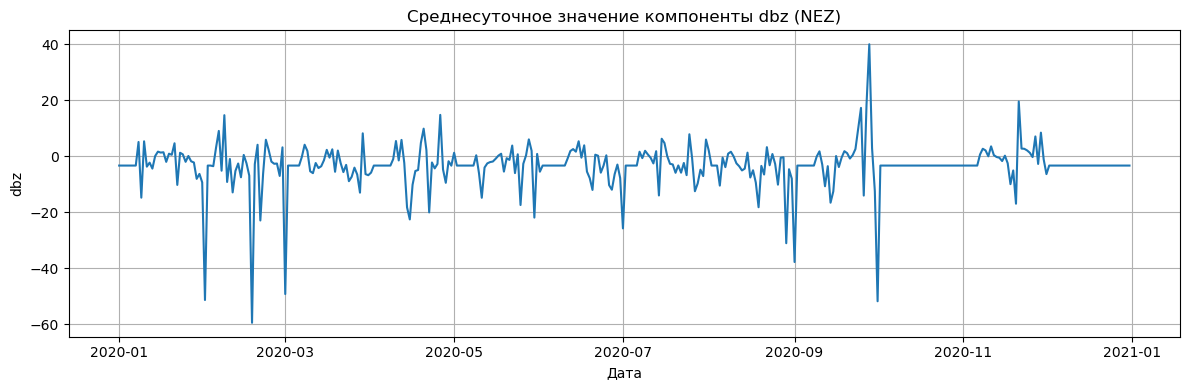

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Загрузка
dataset = Dataset('./data/solar_wind_speed/SuperMAG_60s_ABK_2020_rev-0006.1744225539.netcdf')

# Выбор переменных
dbz = dataset.variables['dbz_nez'][:]
years = dataset.variables['time_yr'][:]
months = dataset.variables['time_mo'][:]
days = dataset.variables['time_dy'][:]
hours = dataset.variables['time_hr'][:]
minutes = dataset.variables['time_mt'][:]

# Проверка формы
print("dbz shape:", dbz.shape)
print("years shape:", years.shape)

# Преобразуем во временные метки
timestamps = pd.to_datetime({
    'year': years.flatten(),
    'month': months.flatten(),
    'day': days.flatten(),
    'hour': hours.flatten(),
    'minute': minutes.flatten()
})

# Преобразуем dbz в 1D (если нужно)
if dbz.ndim > 1:
    dbz = dbz[:, 0]  # или dbz = dbz.squeeze()

# Создаём датафрейм
df = pd.DataFrame({'datetime': timestamps, 'dbz': dbz})
df.set_index('datetime', inplace=True)

# Агрегация по дням
df_daily = df.resample('D').mean()
df_daily = df_daily.fillna(df_daily.mean())

# Построение графика
plt.figure(figsize=(12, 4))
plt.plot(df_daily.index, df_daily['dbz'])
plt.title('Среднесуточное значение компоненты dbz (NEZ)')
plt.xlabel('Дата')
plt.ylabel('dbz')
plt.grid(True)
plt.tight_layout()
plt.show()


Соберём dbz из нескольких файлов в один DataFrame

In [77]:
import os
from netCDF4 import Dataset
import pandas as pd

# Папка с файлами
folder = './data/solar_wind_speed'

# Инициализация списка
all_dbz = []

# Перебираем все netcdf-файлы за 2020–2024
for year in range(2020, 2025):
    filename = f"SuperMAG_60s_ABK_{year}_rev-0006.1744225539.netcdf"
    filepath = os.path.join(folder, filename)

    # Файл может называться иначе (только год отличается)
    # Поэтому ищем подходящий файл в папке
    files = [f for f in os.listdir(folder) if f"SuperMAG_60s_ABK_{year}" in f and f.endswith('.netcdf')]
    if not files:
        continue
    filepath = os.path.join(folder, files[0])

    dataset = Dataset(filepath)

    dbz = dataset.variables['dbz_nez'][:]
    years = dataset.variables['time_yr'][:]
    months = dataset.variables['time_mo'][:]
    days = dataset.variables['time_dy'][:]
    hours = dataset.variables['time_hr'][:]
    minutes = dataset.variables['time_mt'][:]

    timestamps = pd.to_datetime({
        'year': years.flatten(),
        'month': months.flatten(),
        'day': days.flatten(),
        'hour': hours.flatten(),
        'minute': minutes.flatten()
    })

    if dbz.ndim > 1:
        dbz = dbz[:, 0]

    df_year = pd.DataFrame({'datetime': timestamps, 'dbz': dbz})
    df_year.set_index('datetime', inplace=True)
    df_year = df_year.resample('D').mean()
    all_dbz.append(df_year)

# Объединяем по всем годам
df_dbz = pd.concat(all_dbz)
df_dbz = df_dbz.fillna(df_dbz.mean())  # интерполируем пропуски

# Добавим колонку даты
df_dbz = df_dbz.reset_index().rename(columns={'datetime': 'date'})


In [78]:
# Уже у тебя есть — переименуем столбец для совместимости
df_temp = df_temp.rename(columns={'date': 'date', 'avg_temp': 'temperature'})

In [79]:
# Уже у тебя есть — просто переименуем для объединения
df_wind = df_wind.rename(columns={'date': 'date', 'max_wind_speed_10m': 'wind_speed'})


In [80]:
# Объединение по дате
df_full = df_dbz.merge(df_temp, on='date').merge(df_wind, on='date')

# Сортируем по дате
df_full = df_full.sort_values('date')

# Показываем итог
print(df_full.head())


        date       dbz  temperature  wind_speed
0 2020-01-01  0.696328        -2.65        12.0
1 2020-01-02  0.696328         1.45        25.7
2 2020-01-03  0.696328        -0.85        16.8
3 2020-01-04  0.696328        -4.75        24.1
4 2020-01-05  0.696328        -7.60        16.0


In [81]:
df_full

,date,dbz,temperature,wind_speed
0,2020-01-01,0.696328,-2.65,12.0
1,2020-01-02,0.696328,1.45,25.7
2,2020-01-03,0.696328,-0.85,16.8
3,2020-01-04,0.696328,-4.75,24.1
4,2020-01-05,0.696328,-7.60,16.0
...,...,...,...,...
1822,2024-12-27,3.046151,1.15,28.1
1823,2024-12-28,-1.131443,0.85,19.0
1824,2024-12-29,-6.398921,-3.55,26.9
1825,2024-12-30,-3.588761,-2.55,34.8


#### Проверка на пропуски

In [82]:
# Проверка количества пропущенных значений в каждом столбце
missing_summary = df_full.isnull().sum()
print("Пропущенные значения по столбцам:\n", missing_summary)

# Процент пропущенных
missing_percent = (df_full.isnull().mean() * 100).round(2)
print("\nПроцент пропущенных значений:\n", missing_percent)


Пропущенные значения по столбцам:
 date           0
dbz            0
temperature    0
wind_speed     0
dtype: int64

Процент пропущенных значений:
 date           0.0
dbz            0.0
temperature    0.0
wind_speed     0.0
dtype: float64


## EDA анализ

#### 1. Общая информация и описательная статистика

In [83]:
print(df_full.info())
print("\nСтатистика по числовым признакам:")
print(df_full.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1826
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1827 non-null   datetime64[ns]
 1   dbz          1827 non-null   float32       
 2   temperature  1827 non-null   float64       
 3   wind_speed   1827 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 64.2 KB
None

Статистика по числовым признакам:
               dbz  temperature   wind_speed
count  1827.000000  1827.000000  1827.000000
mean      0.696328     1.541325    15.213629
std      15.571753     8.365840     6.114621
min    -200.117188   -21.650000     2.600000
25%      -3.736934    -4.350000    10.900000
50%       0.696328     1.000000    14.200000
75%       3.149749     8.225000    18.500000
max     168.947784    22.000000    55.200000


#### 2. Распределения признаков

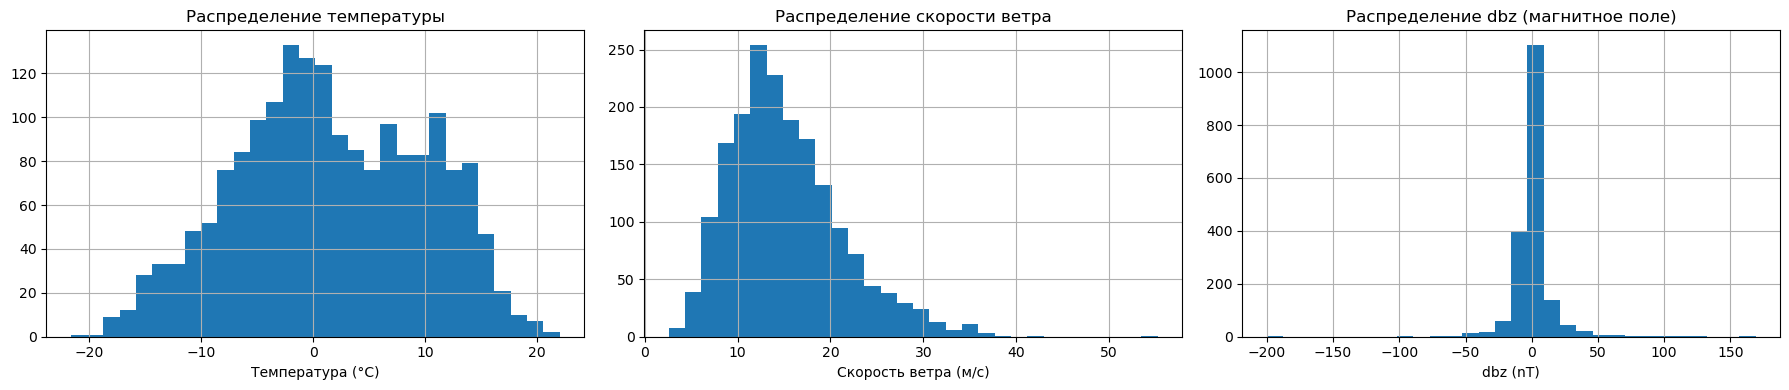

In [84]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

df_full['temperature'].hist(ax=axes[0], bins=30)
axes[0].set_title('Распределение температуры')
axes[0].set_xlabel('Температура (°C)')

df_full['wind_speed'].hist(ax=axes[1], bins=30)
axes[1].set_title('Распределение скорости ветра')
axes[1].set_xlabel('Скорость ветра (м/с)')

df_full['dbz'].hist(ax=axes[2], bins=30)
axes[2].set_title('Распределение dbz (магнитное поле)')
axes[2].set_xlabel('dbz (nT)')

plt.tight_layout()
plt.show()


#### 3. Временные ряды (поведение по времени)

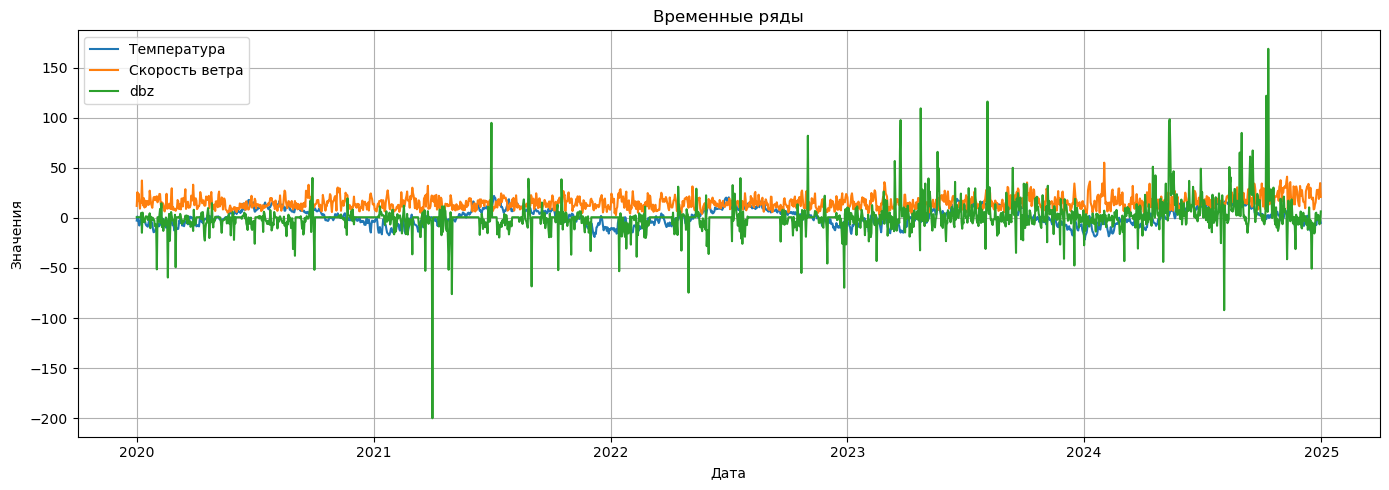

In [85]:
plt.figure(figsize=(14, 5))
plt.plot(df_full['date'], df_full['temperature'], label='Температура')
plt.plot(df_full['date'], df_full['wind_speed'], label='Скорость ветра')
plt.plot(df_full['date'], df_full['dbz'], label='dbz')
plt.title('Временные ряды')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4. Корреляции между признаками

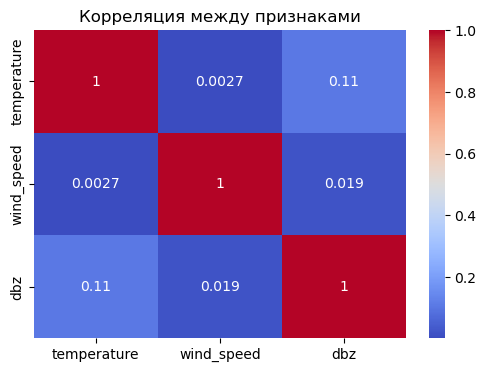

In [86]:
import seaborn as sns

corr = df_full[['temperature', 'wind_speed', 'dbz']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками')
plt.show()


#### 5. Парные графики (если нужно визуально сравнить попарно)

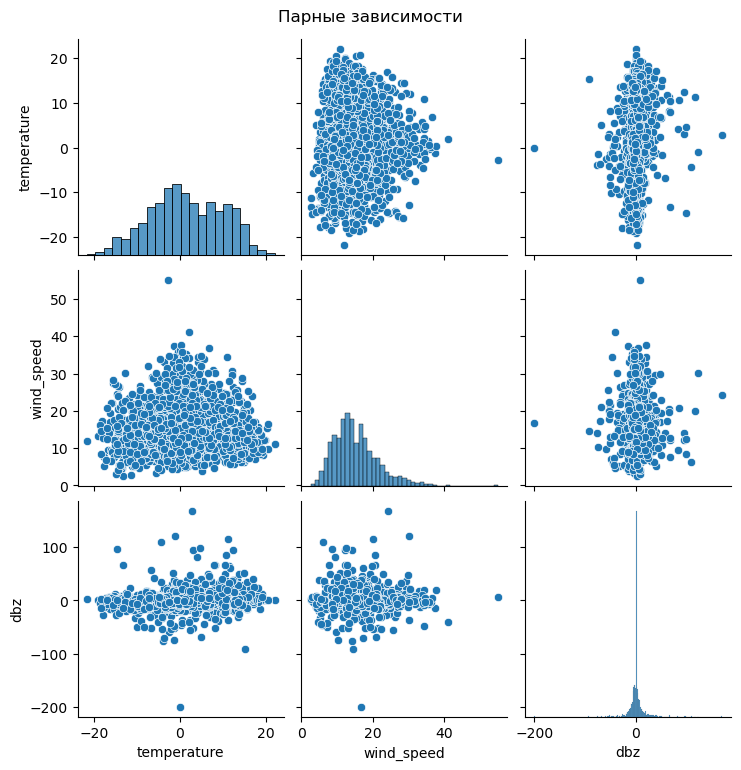

In [87]:
sns.pairplot(df_full[['temperature', 'wind_speed', 'dbz']])
plt.suptitle("Парные зависимости", y=1.02)
plt.show()


## Анализ графиков

#### 1. Распределения (гистограммы)

|Признак|	Наблюдения|
|-|-|
|Температура|	распределена примерно нормально, но слегка смещена влево (больше дней с отрицательной температурой — ожидаемо для высоких широт).|
|Скорость ветра|	слегка скошено вправо: большинство значений до 20 м/с, но встречаются и выбросы до 50+.|
|dbz (магнитное поле)|	острое, симметричное распределение с «тонким хвостом», большинство значений сконцентрированы близко к 0.|

#### 2. Временные ряды

- У всех признаков есть сезонные колебания:

    - Температура хорошо показывает годовой цикл.

    - Ветер и dbz имеют более хаотичное распределение, но у dbz заметны всплески — возможные геомагнитные события.

- Иногда dbz выстреливает вверх/вниз — это может быть следствием солнечных бурь или сильной геомагнитной активности (влияние на северное сияние?).

#### 3. Корреляционная матрица

|Пара|	Коэфф.|	Комментарий|
|-|-|-|
|Температура ↔ Ветер|	~0.002	|фактически нет связи|
|Температура ↔ dbz|	~0.11	|слабая положительная корреляция|
|Ветер ↔ dbz|	~0.02	|практически отсутствует связь|

**Вывод**: между температурой, ветром и dbz нет выраженной линейной зависимости. Но это не исключает нелинейных связей или событийной зависимости (например, dbz резко меняется только при определённых комбинациях условий).

#### 4. Парные зависимости

- dbz не образует внятных трендов ни с температурой, ни со скоростью ветра.

- Точки разбросаны облаком вокруг центра, но не вдоль линии — подтверждает низкую корреляцию.

## Общий вывод:

- Температура имеет закономерную сезонность.

- dbz демонстрирует «вспышки» — стоит изучить, с какими днями они совпадают (солнечные бури, всплески ветра?).

- Линейной корреляции между dbz и другими параметрами не обнаружено, но:

    - возможно влияние через событийный анализ: дни с dbz > X → какие условия были?

    - можно попробовать кластеризацию, детектирование аномалий, нелинейные модели (например, деревья решений, XGBoost).